In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")   

---
### Произведем объединение первичных данных

In [3]:
# Загрузка данных
def load_data():
    customers = pd.read_csv("./clean_data/customers.csv")
    geolocation = pd.read_csv("./clean_data/geolocation.csv")
    order_pay = pd.read_csv("./clean_data/order_payments.csv")
    reviews = pd.read_csv("./clean_data/order_reviews.csv")
    orders = pd.read_csv("./clean_data/orders.csv")
    item = pd.read_csv("./clean_data/orders_items.csv")
    category_name = pd.read_csv(
        "./clean_data/product_category_name_translation.csv")
    products = pd.read_csv("./clean_data/products.csv")
    sellers = pd.read_csv("./clean_data/sellers.csv")
    return customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers


In [4]:
# Объединение данных
def merge_data(orders, item, order_pay, reviews, products, customers, sellers, category_name):
    df = orders.merge(item, on='order_id', how='left')
    df = df.merge(order_pay, on='order_id', how='outer', validate='m:m')
    df = df.merge(reviews, on='order_id', how='outer')
    df = df.merge(products, on='product_id', how='outer')
    df = df.merge(customers, on='customer_id', how='outer')
    df = df.merge(sellers, on='seller_id', how='outer')
    df = df.merge(category_name, on="product_category_name", how="left")
    return df

In [5]:
# Очистка данных: удаление строк без customer_unique_id
def filter_customers(df):
    return df[~df["customer_unique_id"].isna()]

In [6]:
# Главная функция пайплайна
def main_pipeline():
    # Шаг 1: Загрузка данных
    customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers = load_data()

    # Шаг 2: Объединение данных
    df = merge_data(orders, item, order_pay, reviews, products,
                    customers, sellers, category_name)

    # Шаг 3: Фильтрация данных
    df = filter_customers(df)

    final_data = df

    return final_data

In [7]:
data = main_pipeline()

---
### Выведем ключевую информацию, проверим пропуски и дубликаты.

In [8]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502.0,umuarama,PR,9080.0,santo andre,SP,small_appliances
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490.0,entre rios de minas,MG,9080.0,santo andre,SP,small_appliances
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600.0,paracatu,MG,9080.0,santo andre,SP,small_appliances
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118686 entries, 0 to 118810
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115706 non-null  object 
 1   customer_id                    118686 non-null  object 
 2   order_status                   115706 non-null  object 
 3   order_purchase_timestamp       115706 non-null  object 
 4   order_approved_at              115706 non-null  object 
 5   order_delivered_carrier_date   115706 non-null  object 
 6   order_delivered_customer_date  115706 non-null  object 
 7   order_estimated_delivery_date  115706 non-null  object 
 8   order_item_id                  115706 non-null  float64
 9   product_id                     115706 non-null  object 
 10  seller_id                      115706 non-null  object 
 11  shipping_limit_date            115706 non-null  object 
 12  price                          1157

In [10]:
data.isna().sum()

order_id                         2980
customer_id                         0
order_status                     2980
order_purchase_timestamp         2980
order_approved_at                2980
order_delivered_carrier_date     2980
order_delivered_customer_date    2980
order_estimated_delivery_date    2980
order_item_id                    2980
product_id                       2980
seller_id                        2980
shipping_limit_date              2980
price                            2980
freight_value                    2980
payment_sequential               2983
payment_type                     2983
payment_installments             2983
payment_value                    2983
review_id                        3841
review_score                     3841
review_creation_date             3841
review_answer_timestamp          3841
product_category_name            4618
product_name_lenght              4618
product_description_lenght       4618
product_photos_qty               4618
product_weig

In [11]:
data.dropna(inplace=True)

In [12]:
data.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm   

In [13]:
data.duplicated().sum()

0

---

---
### Начнем вычленение и конфигурацию комбинированных признаков для формирования субдатасета последующей кластеризации.

In [14]:
clients_city = data[["customer_unique_id", "customer_city"]]
clients_city = clients_city.drop_duplicates()

In [ ]:
# Сформируем информацию по количеству покупок
orderer_by_client = data.groupby(["customer_unique_id",])[
    ["order_id"]].count().reset_index().rename(columns={"order_id":"num_orders"})


orderer_by_client

,customer_unique_id,num_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
91460,fffcf5a5ff07b0908bd4e2dbc735a684,2
91461,fffea47cd6d3cc0a88bd621562a9d061,1
91462,ffff371b4d645b6ecea244b27531430a,1
91463,ffff5962728ec6157033ef9805bacc48,1


In [ ]:
# Сформируем информацию по статистикам платежей и рейтингов выставляемых пользователями.
payments_ratings = data.groupby("customer_unique_id")[
    ["payment_value", "payment_installments", "price", "review_score"]].agg(
        ["min", "max", "mean"]).reset_index()
payments_ratings.columns = ['_'.join(col).strip('_') for col in payments_ratings.columns.values]

payments_ratings

,customer_unique_id,payment_value_min,payment_value_max,payment_value_mean,payment_installments_min,payment_installments_max,payment_installments_mean,price_min,price_max,price_mean,review_score_min,review_score_max,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,141.90,141.90,8.0,8.0,8.0,129.90,129.90,129.90,5.0,5.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,27.19,27.19,1.0,1.0,1.0,18.90,18.90,18.90,4.0,4.0,4.0
2,0000f46a3911fa3c0805444483337064,86.22,86.22,86.22,8.0,8.0,8.0,69.00,69.00,69.00,3.0,3.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,43.62,43.62,4.0,4.0,4.0,25.99,25.99,25.99,4.0,4.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,196.89,196.89,196.89,6.0,6.0,6.0,180.00,180.00,180.00,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91460,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,2067.42,2067.42,10.0,10.0,10.0,680.00,890.00,785.00,5.0,5.0,5.0
91461,fffea47cd6d3cc0a88bd621562a9d061,84.58,84.58,84.58,1.0,1.0,1.0,64.89,64.89,64.89,4.0,4.0,4.0
91462,ffff371b4d645b6ecea244b27531430a,112.46,112.46,112.46,1.0,1.0,1.0,89.90,89.90,89.90,5.0,5.0,5.0
91463,ffff5962728ec6157033ef9805bacc48,133.69,133.69,133.69,5.0,5.0,5.0,115.00,115.00,115.00,5.0,5.0,5.0


In [ ]:
# Сформируем информацию по синтетическому временному признаку life_span в секундах отмечающую продложительность
# взаимодействия клиента с площадкой.
data["order_purchase_timestamp"] = pd.to_datetime(
    data["order_purchase_timestamp"])
first_last_order = data.groupby("customer_unique_id")[
    "order_purchase_timestamp"].agg(["min", "max", "mean"]).reset_index().rename(
        columns={"min": "first_order", "max": "last_order"})

first_last_order["life_span"] = first_last_order["last_order"] - \
    first_last_order["first_order"]


life_span = first_last_order[["customer_unique_id", "life_span"]].copy()

life_span["life_span"] = life_span["life_span"].dt.seconds

life_span

,customer_unique_id,life_span
0,0000366f3b9a7992bf8c76cfdf3221e2,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,0
4,0004aac84e0df4da2b147fca70cf8255,0
...,...,...
91460,fffcf5a5ff07b0908bd4e2dbc735a684,0
91461,fffea47cd6d3cc0a88bd621562a9d061,0
91462,ffff371b4d645b6ecea244b27531430a,0
91463,ffff5962728ec6157033ef9805bacc48,0


In [ ]:
# Сформируем информацию по модальной категории продуктов в разрезе пользователей
def calculate_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

mode_category = (
    data.groupby("customer_unique_id")["product_category_name_english"]
    .agg(calculate_mode)
    .reset_index()
)

mode_category.columns = ["customer_unique_id", "most_frequent_product_category"]

mode_category


,customer_unique_id,most_frequent_product_category
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty
2,0000f46a3911fa3c0805444483337064,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,telephony
4,0004aac84e0df4da2b147fca70cf8255,telephony
...,...,...
91460,fffcf5a5ff07b0908bd4e2dbc735a684,health_beauty
91461,fffea47cd6d3cc0a88bd621562a9d061,baby
91462,ffff371b4d645b6ecea244b27531430a,auto
91463,ffff5962728ec6157033ef9805bacc48,watches_gifts


---

### Начнем формировать датасет для кластеризации

In [19]:
clients_data_1 = orderer_by_client.merge(
    payments_ratings, on="customer_unique_id")
clients_data_2 = life_span.merge(mode_category, on="customer_unique_id")
clients_data = clients_data_1.merge(
    clients_data_2, on="customer_unique_id")

clients_data_full = clients_data.merge(clients_city, on="customer_unique_id")


labels = LabelEncoder()
st_scaler = StandardScaler()

clients_data_full["most_frequent_product_category"] = labels.fit_transform(
    clients_data_full["most_frequent_product_category"])

clients_data_full["customer_city"] = labels.fit_transform(
    clients_data_full["customer_city"])

clients_data_full

,customer_unique_id,num_orders,payment_value_min,payment_value_max,payment_value_mean,payment_installments_min,payment_installments_max,payment_installments_mean,price_min,price_max,price_mean,review_score_min,review_score_max,review_score_mean,life_span,most_frequent_product_category,customer_city
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,141.90,8.0,8.0,8.0,129.90,129.90,129.90,5.0,5.0,5.0,0,7,647
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,27.19,1.0,1.0,1.0,18.90,18.90,18.90,4.0,4.0,4.0,0,43,2564
2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,86.22,8.0,8.0,8.0,69.00,69.00,69.00,3.0,3.0,3.0,0,66,3477
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,43.62,4.0,4.0,4.0,25.99,25.99,25.99,4.0,4.0,4.0,0,68,443
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,196.89,6.0,6.0,6.0,180.00,180.00,180.00,5.0,5.0,5.0,0,68,3713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91571,fffcf5a5ff07b0908bd4e2dbc735a684,2,2067.42,2067.42,2067.42,10.0,10.0,10.0,680.00,890.00,785.00,5.0,5.0,5.0,0,43,3217
91572,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,84.58,84.58,1.0,1.0,1.0,64.89,64.89,64.89,4.0,4.0,4.0,0,6,1311
91573,ffff371b4d645b6ecea244b27531430a,1,112.46,112.46,112.46,1.0,1.0,1.0,89.90,89.90,89.90,5.0,5.0,5.0,0,5,3695
91574,ffff5962728ec6157033ef9805bacc48,1,133.69,133.69,133.69,5.0,5.0,5.0,115.00,115.00,115.00,5.0,5.0,5.0,0,70,511


<Axes: >

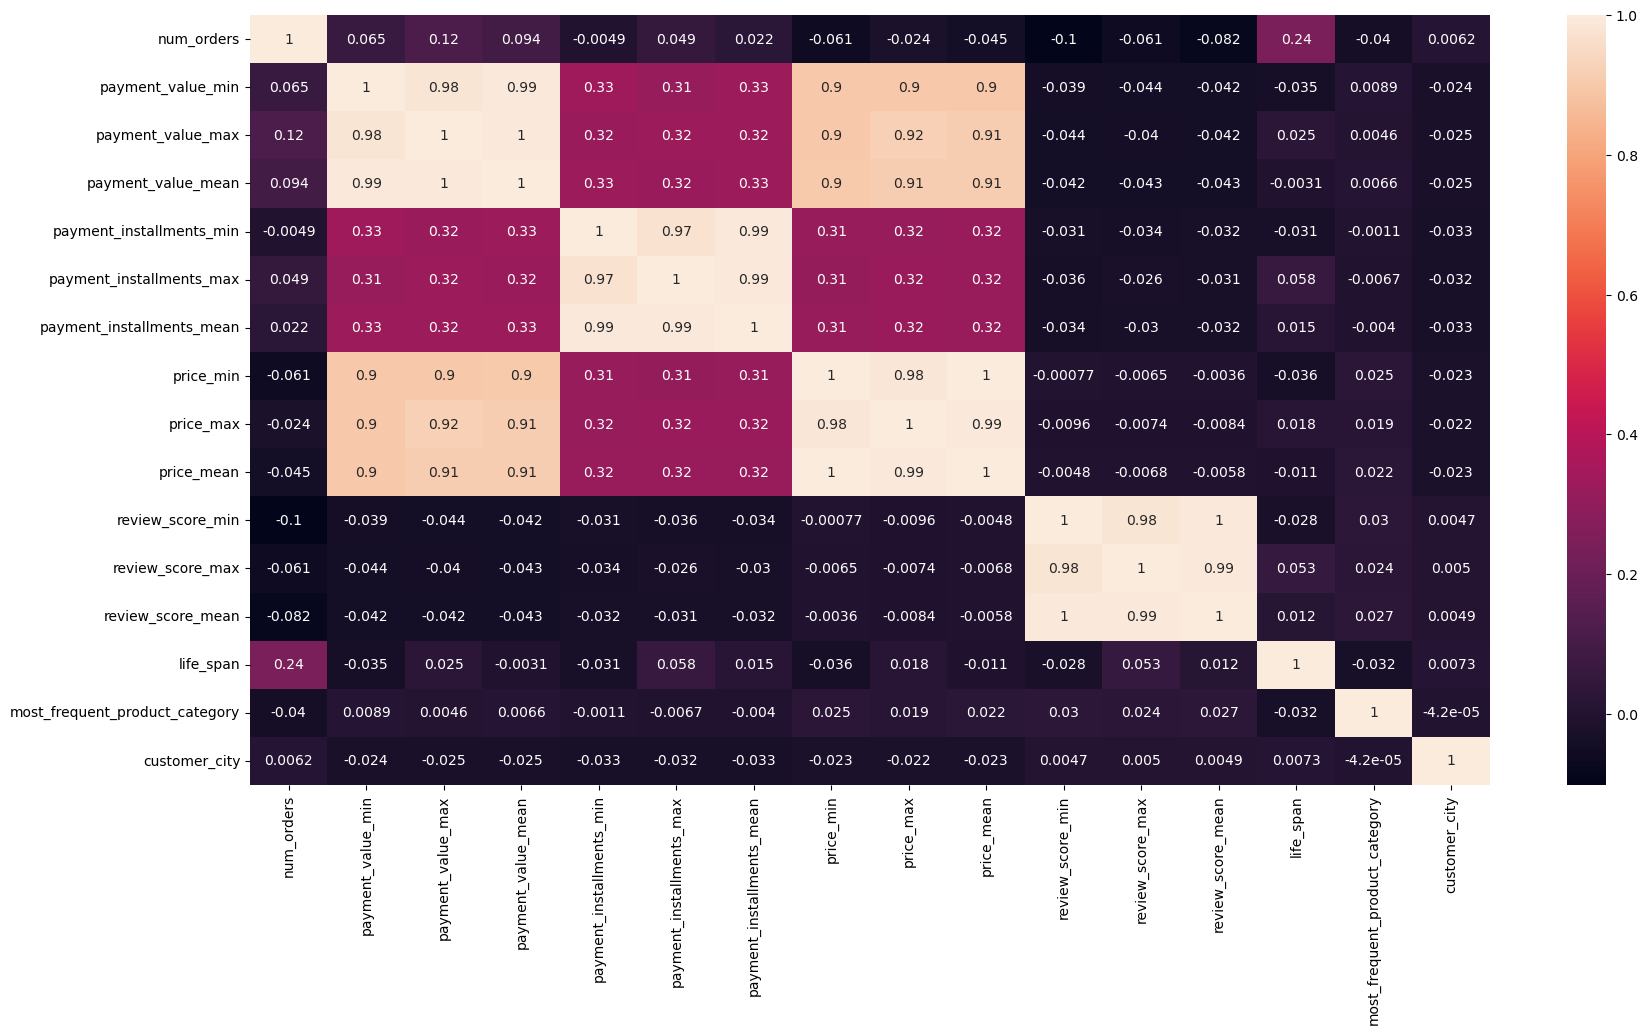

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(clients_data_full.iloc[:,1:].corr(), annot=True)

> Можно наблюдать наличие мультиколлинеарности, дропнем скоррелированные фиты для того что бы не снижать размерность и остаться в интрерпретируемом признаковом пространстве.

<Axes: >

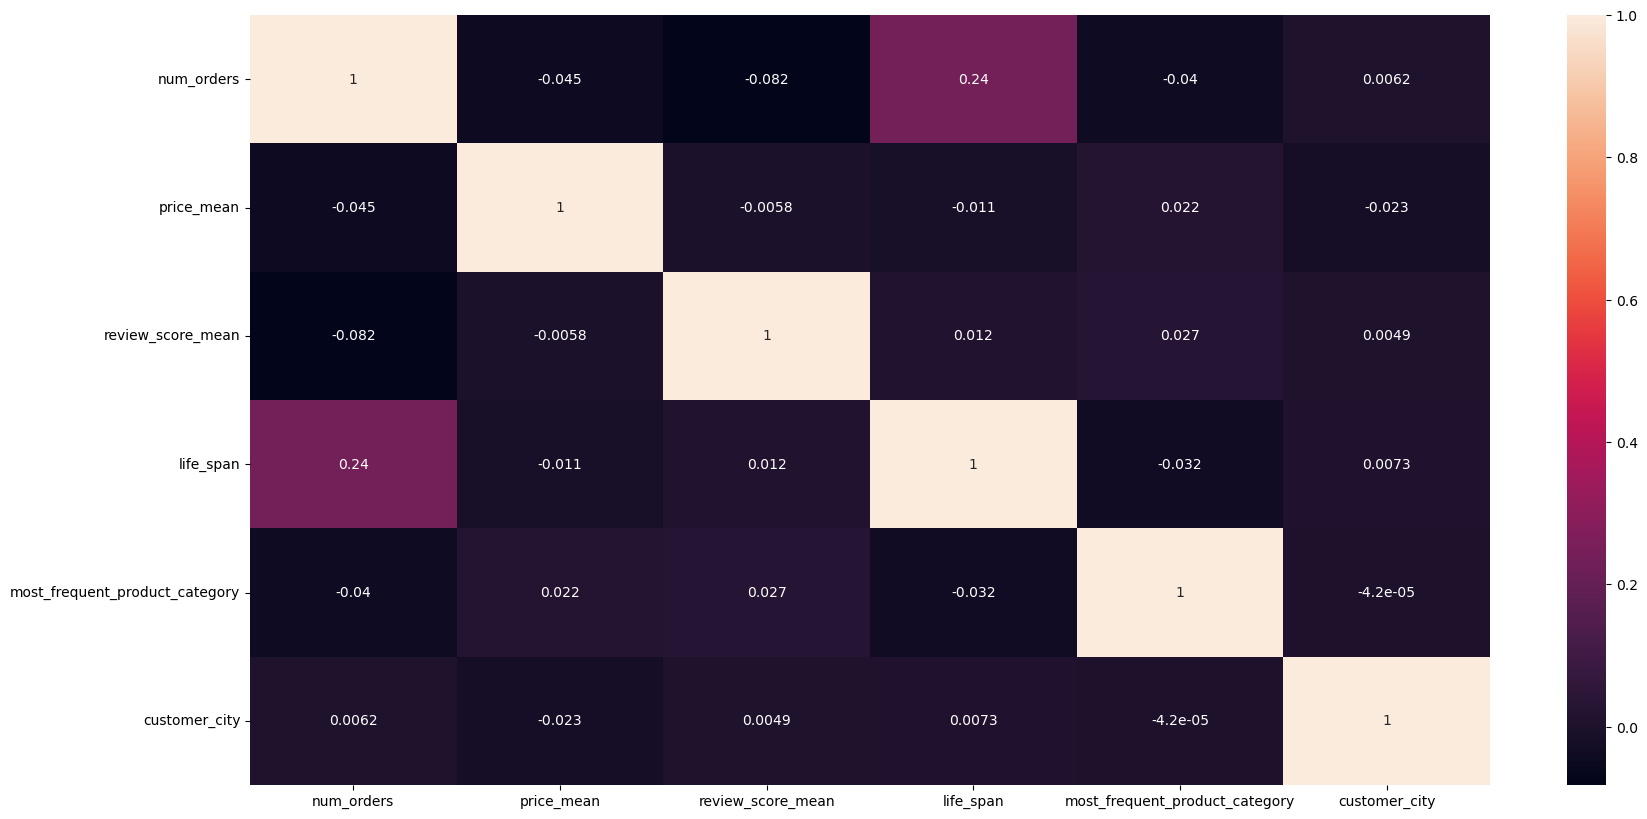

In [21]:
columns_to_drop = [
    "payment_value_min", "payment_value_max", "price_min", "payment_value_mean",
    "price_max", "payment_installments_min", "payment_installments_max", 
    "payment_installments_mean", "review_score_min", "review_score_max"
    ]

clients_data_cleaned = clients_data_full.drop(columns=columns_to_drop)


fig, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(clients_data_cleaned.iloc[:,1:].corr(), annot=True)

> Мультиколлинеарность побороли.
---
### Начинаем кластеризовать

In [22]:
X = clients_data_cleaned.iloc[:,1:]
X

,num_orders,price_mean,review_score_mean,life_span,most_frequent_product_category,customer_city
0,1,129.90,5.0,0,7,647
1,1,18.90,4.0,0,43,2564
2,1,69.00,3.0,0,66,3477
3,1,25.99,4.0,0,68,443
4,1,180.00,5.0,0,68,3713
...,...,...,...,...,...,...
91571,2,785.00,5.0,0,43,3217
91572,1,64.89,4.0,0,6,1311
91573,1,89.90,5.0,0,5,3695
91574,1,115.00,5.0,0,70,511


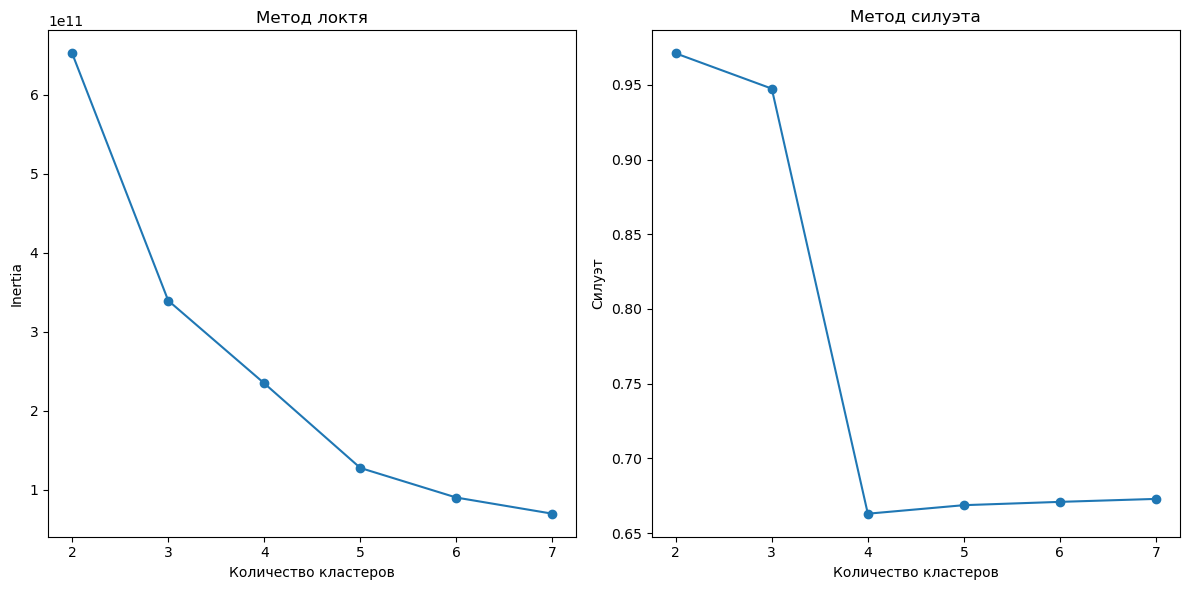

In [23]:
# Метод локтя
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 8)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    
    inertia.append(kmeans.inertia_)
    
    # Предсказание кластеров и расчет коэффициента силуэта
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Визуализация метода локтя
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)

# Визуализация метода силуэта
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Метод силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')
plt.xticks(range_n_clusters)

plt.tight_layout()
plt.show()

> Оптимум по количеству кластеров = 3 исходя их паритета инерции и межкластерного расстояния

----
### На основе полученных гиперпараметров кластеризуем и получим метки классов

In [24]:
k_means_whole = KMeans(n_clusters=3, random_state=42)
k_means_whole.fit(X)

clients_data_cleaned["labels"] = k_means_whole.labels_
clients_data_cleaned

,customer_unique_id,num_orders,price_mean,review_score_mean,life_span,most_frequent_product_category,customer_city,labels
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,0,7,647,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,0,43,2564,0
2,0000f46a3911fa3c0805444483337064,1,69.00,3.0,0,66,3477,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,0,68,443,0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,0,68,3713,0
...,...,...,...,...,...,...,...,...
91571,fffcf5a5ff07b0908bd4e2dbc735a684,2,785.00,5.0,0,43,3217,0
91572,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,4.0,0,6,1311,0
91573,ffff371b4d645b6ecea244b27531430a,1,89.90,5.0,0,5,3695,0
91574,ffff5962728ec6157033ef9805bacc48,1,115.00,5.0,0,70,511,0


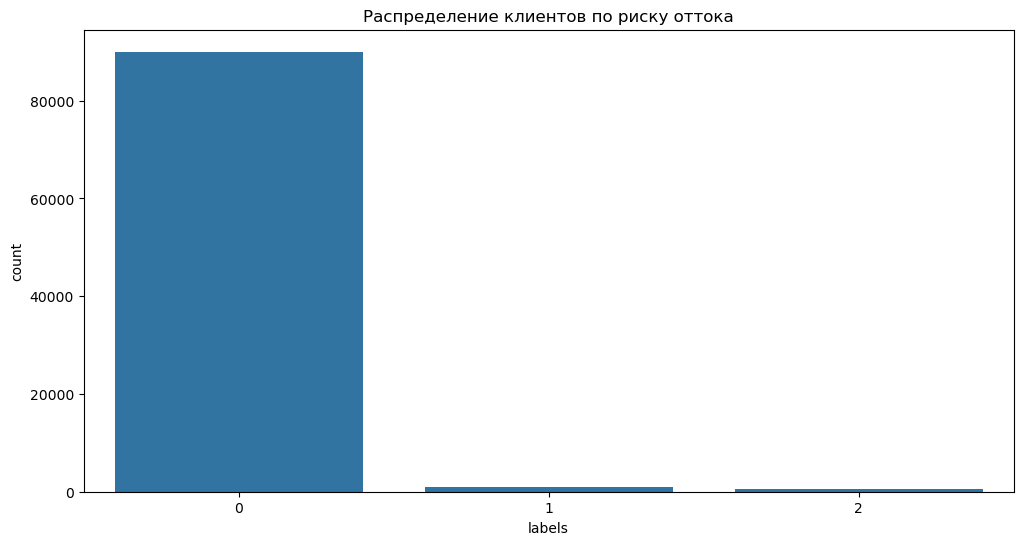

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='labels', data=clients_data_cleaned)
plt.title('Распределение клиентов по риску оттока')
plt.savefig("./labels/kmeans_chart.png", dpi=300, bbox_inches='tight')
plt.show()

> Можно сделать предположение о том, что кластер 0 сформирован побольшей части из покупателей с 1 покупкой, классы 1 и 2 могут отвечать за лояльных клиентов.

In [27]:
clients_data_cleaned["labels"].value_counts()

labels
0    90033
1      944
2      599
Name: count, dtype: int64

In [28]:
clients_data_cleaned.to_csv("./labels/kmeans.csv", index=False)